<a href="https://colab.research.google.com/github/marco-siino/HAR_IEEE_Transaction_Wireless/blob/main/CNN_HAR__IEEE_Transaction_Wireless.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Import the libraries.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
import os

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, LSTM, TimeDistributed, Conv1D, MaxPooling1D,GlobalAveragePooling1D
from tensorflow.keras.optimizers import RMSprop, AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import seaborn as sns


In [5]:
# Configura TensorFlow per l'uso di GPU (se più GPU disponibili, puoi selezionare quale utilizzare)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print(f"GPU {physical_devices[0]} selezionata per l'addestramento.")
else:
    print("Nessuna GPU trovata, verrà usata la CPU.")

GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') selezionata per l'addestramento.


In [6]:
# Imposta il seed per garantire la riproducibilità
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Download the dataset.

In [7]:
df_phases = pd.read_csv("https://drive.google.com/uc?export=download&id=1FgBhUPHnNlp6JO2ryxZzeKq1CrXra9OQ",index_col=[0, 1])
print(df_phases)

                   0         1         2         3  ...           124       125       126       127
scene time                                          ...                                            
S0    1    -0.000008 -0.000031  0.000032 -1.829135  ... -1.748980e-07 -0.000037  0.000037 -1.575557
      2    -0.000006 -0.000031  0.000031 -1.767153  ... -1.433180e-07 -0.000035  0.000035 -1.574867
      3    -0.000006 -0.000031  0.000031 -1.767153  ... -1.433180e-07 -0.000035  0.000035 -1.574867
      4    -0.000008 -0.000031  0.000032 -1.829135  ... -1.748980e-07 -0.000037  0.000037 -1.575557
      5    -0.000008 -0.000031  0.000032 -1.829135  ... -1.748980e-07 -0.000037  0.000037 -1.575557
...              ...       ...       ...       ...  ...           ...       ...       ...       ...
S2    6    -0.000006 -0.000031  0.000031 -1.767153  ... -1.433180e-07 -0.000035  0.000035 -1.574867
      7    -0.000005 -0.000030  0.000030 -1.751098  ... -9.947210e-07 -0.000034  0.000034 -1.599758


In [8]:
X = df_phases.iloc[:, :128].values

# Prendiamo le etichette della scena
y = df_phases.index.get_level_values(0).values

# Passo 1: Rimodellare le feature in blocchi (32 righe, 4 colonne)
X_reshaped = X.reshape(-1, 32, 4)  # Ogni riga diventa una matrice 32x4

# Passo 2: Creare i blocchi 10x (320x4)
num_samples = X_reshaped.shape[0] - 9  # Numero di batch possibili
X_batches = []
y_batches = []

for i in range(num_samples):
    scene_batch = y[i:i+10]  # Scene associate al batch di 10 righe

    if len(set(scene_batch)) == 1:  # Controlliamo che tutte le righe appartengano alla stessa scena
        X_batches.append(X_reshaped[i:i+10].reshape(320, 4))
        y_batches.append(scene_batch[0])  # Prendiamo la label della prima riga

# Convertiamo in array NumPy
X_batches = np.array(X_batches)  # (num_validi, 320, 4)
y_batches = np.array(y_batches)  # (num_validi,)

# Passo 3: Convertire le etichette in numeri interi
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_batches)

# Passo 4: Convertire le etichette in one-hot encoding
y_categorical = to_categorical(y_encoded)

print(f"Shape finale di X: {X_batches.shape}")  # (num_validi, 320, 4)
print(f"Shape finale di y (one-hot): {y_categorical.shape}")  # (num_validi, num_classi)

Shape finale di X: (29943, 320, 4)
Shape finale di y (one-hot): (29943, 3)


In [9]:
print(X_batches)
print(X_batches.shape)
print(X_batches[0])
print(X_batches[0].shape)
print("label associata:",y[0])

[[[-8.144310e-06 -3.082130e-05  3.187918e-05 -1.829135e+00]
  [-1.760110e-05  2.366990e-05  2.949683e-05  2.210193e+00]
  [ 3.261130e-05 -1.773020e-07  3.261178e-05 -5.436774e-03]
  ...
  [-2.568760e-05  5.230830e-06  2.621477e-05  2.940707e+00]
  [ 2.359750e-05  1.675880e-05  2.894304e-05  6.175348e-01]
  [-1.433180e-07 -3.520620e-05  3.520649e-05 -1.574867e+00]]

 [[-6.076110e-06 -3.054550e-05  3.114397e-05 -1.767153e+00]
  [-1.842920e-05  2.195660e-05  2.866579e-05  2.269073e+00]
  [ 3.178240e-05  1.282870e-06  3.180828e-05  4.034226e-02]
  ...
  [-2.568760e-05  5.230830e-06  2.621477e-05  2.940707e+00]
  [ 2.359750e-05  1.675880e-05  2.894304e-05  6.175348e-01]
  [-1.433180e-07 -3.520620e-05  3.520649e-05 -1.574867e+00]]

 [[-6.076110e-06 -3.054550e-05  3.114397e-05 -1.767153e+00]
  [-1.842920e-05  2.195660e-05  2.866579e-05  2.269073e+00]
  [ 3.178240e-05  1.282870e-06  3.180828e-05  4.034226e-02]
  ...
  [-2.720560e-05  5.953730e-06  2.784944e-05  2.926147e+00]
  [ 2.501220e-05  

In [10]:
indices = np.arange(len(X_batches))
np.random.shuffle(indices)

# Riordiniamo i dati e le etichette usando gli stessi indici
X_batches_shuffled = X_batches[indices]  # Shuffle solo delle matrici
y_categorical_shuffled = y_categorical[indices]  # Le label restano abbinate

In [11]:
print(X_batches_shuffled)
print(X_batches_shuffled.shape)
print(X_batches_shuffled[0])
print(X_batches_shuffled[0].shape)
print("label associata:",y_categorical_shuffled[0])

[[[-1.792730e-05 -3.989300e-05  4.373602e-05 -1.993138e+00]
  [-2.708500e-05  3.571980e-05  4.482746e-05  2.219565e+00]
  [ 4.544130e-05  8.811800e-06  4.628779e-05  1.915389e-01]
  ...
  [-4.085800e-05  8.803960e-06  4.179576e-05  2.929361e+00]
  [ 2.918610e-05  3.102300e-05  4.259407e-05  8.158974e-01]
  [ 1.151820e-05 -4.158770e-05  4.315328e-05 -1.300607e+00]]

 [[-9.075650e-06 -3.170370e-05  3.297714e-05 -1.849605e+00]
  [-1.812190e-05  2.481400e-05  3.072683e-05  2.201576e+00]
  [ 3.359110e-05  5.097600e-08  3.359114e-05  1.517544e-03]
  ...
  [-2.687510e-05  5.585030e-06  2.744929e-05  2.936695e+00]
  [ 2.434800e-05  1.755680e-05  3.001777e-05  6.247325e-01]
  [ 1.562660e-07 -3.615690e-05  3.615724e-05 -1.566474e+00]]

 [[-6.076110e-06 -3.054550e-05  3.114397e-05 -1.767153e+00]
  [-1.842920e-05  2.195660e-05  2.866579e-05  2.269073e+00]
  [ 3.178240e-05  1.282870e-06  3.180828e-05  4.034226e-02]
  ...
  [-2.888900e-05  9.924180e-07  2.890604e-05  3.107253e+00]
  [ 1.915580e-05  

#SOLO TRAIN E VAL

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_batches_shuffled, y_categorical_shuffled, test_size=0.3, random_state=42)


In [24]:
#print(X_train)
print(X_train.shape)
#print(y_train)
print(y_train.shape)

(20960, 320, 4)
(20960, 3)


In [29]:
# Numero di fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Liste per memorizzare i set di train e test per ogni fold
X_train_folds = []
X_test_folds = []
y_train_folds = []
y_test_folds = []

# Suddividi il dataset in 5 fold
for train_idx, test_idx in skf.split(X_batches_shuffled, np.argmax(y_categorical_shuffled, axis=1)):
    X_train_folds.append(X_batches_shuffled[train_idx])
    X_test_folds.append(X_batches_shuffled[test_idx])
    y_train_folds.append(y_categorical_shuffled[train_idx])
    y_test_folds.append(y_categorical_shuffled[test_idx])

# Converti le liste in array numpy per avere lo stesso formato dello split normale
X_train = np.array(X_train_folds, dtype=object)
X_test = np.array(X_test_folds, dtype=object)
y_train = np.array(y_train_folds, dtype=object)
y_test = np.array(y_test_folds, dtype=object)

# Stampa delle dimensioni per il primo fold (per verificare)
print(X_train[0].shape)  # Dovrebbe essere simile a (20960, 320, 4)
print(y_train[0].shape)  # Dovrebbe essere simile a (20960, 3)


(23954, 320, 4)
(23954, 3)


In [13]:
print(X_train[0])
print(X_train[0].shape)

[[[-9.075650e-06 -3.170370e-05  3.297714e-05 -1.849605e+00]
  [-1.812190e-05  2.481400e-05  3.072683e-05  2.201576e+00]
  [ 3.359110e-05  5.097600e-08  3.359114e-05  1.517544e-03]
  ...
  [-2.687510e-05  5.585030e-06  2.744929e-05  2.936695e+00]
  [ 2.434800e-05  1.755680e-05  3.001777e-05  6.247325e-01]
  [ 1.562660e-07 -3.615690e-05  3.615724e-05 -1.566474e+00]]

 [[-6.076110e-06 -3.054550e-05  3.114397e-05 -1.767153e+00]
  [-1.842920e-05  2.195660e-05  2.866579e-05  2.269073e+00]
  [ 3.178240e-05  1.282870e-06  3.180828e-05  4.034226e-02]
  ...
  [-2.888900e-05  9.924180e-07  2.890604e-05  3.107253e+00]
  [ 1.915580e-05  2.037560e-05  2.796623e-05  8.162449e-01]
  [ 4.040050e-06 -3.078950e-05  3.105343e-05 -1.440327e+00]]

 [[-8.497370e-06 -3.059870e-05  3.175666e-05 -1.841674e+00]
  [-1.741700e-05  2.396010e-05  2.962158e-05  2.199360e+00]
  [ 3.286860e-05 -2.765560e-07  3.286976e-05 -8.413789e-03]
  ...
  [-2.568760e-05  5.230830e-06  2.621477e-05  2.940707e+00]
  [ 2.359750e-05  

In [14]:
def create_improved_cnn_model(input_shape, num_classes):
    model = Sequential()

    # Primo strato convoluzionale 2D
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.1))  # LeakyReLU invece di ELU
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # Secondo strato convoluzionale 2D
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # Terzo strato convoluzionale
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # Aggiungi strato convoluzionale dilatato (dilated convolution)
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.01), dilation_rate=(2, 2)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # Flatten per passare ai layer densi
    model.add(Flatten())

    # Fully Connected con Dropout
    model.add(Dense(512, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.4))  # Ridotto il tasso di dropout

    # Altri layer densi
    model.add(Dense(128, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.4))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compilazione del modello con RMSprop come ottimizzatore
    model.compile(optimizer = AdamW(learning_rate=0.00005, weight_decay=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Creazione del modello
input_shape = (320, 4, 1)  # (altezza, larghezza, canale)
num_classes = y_categorical_shuffled.shape[1]  # Numero di classi uniche


In [15]:
# Callback per migliorare l'addestramento
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Callback per salvare il miglior modello in base a val_accuracy
checkpoint = ModelCheckpoint(
    'best_model.h5',           # Percorso dove salvare il modello
    monitor='val_accuracy',    # La metrica che monitoriamo
    mode='max',                # Cerchiamo di massimizzare la val_accuracy
    save_best_only=True,       # Salva solo il modello con la miglior val_accuracy
    verbose=1                  # Mostra un messaggio ogni volta che viene salvato un modello
)

# Cross Fold Validation

In [21]:
print(y_train[2])

0.0


In [30]:
for i in range(0, n_splits):
  X_train_tmp = X_train[i]
  X_test_tmp = X_test[i]
  y_train_tmp = y_train[i]
  y_test_tmp = y_test[i]
  # Correzione per la forma dei dati di input
  # Aggiungi una dimensione per i canali (dalla forma (26948, 320, 4) a (26948, 320, 4, 1))
  X_train_tmp = X_train_tmp[..., np.newaxis]  # Aggiungi la dimensione dei canali
  X_test_tmp = X_test_tmp[..., np.newaxis]    # Aggiungi la dimensione dei canali per il test

  # Verifica la nuova forma
  print(X_train.shape)  # Ora dovrebbe essere (26948, 320, 4, 1)

  model = create_improved_cnn_model(input_shape, num_classes)
  model.summary()

  # Addestramento del modello senza data augmentation
  history = model.fit(
      X_train_tmp, y_train_tmp,          # Usa direttamente X_train e y_train senza augmentation
      epochs=1, batch_size=64,
      validation_data=(X_test_tmp, y_test_tmp),
      callbacks=[reduce_lr, early_stopping, checkpoint]  # Aggiungi la callback checkpoint
  )


(5,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 320, 4, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_30 (LeakyReLU)           │ (None, 320, 4, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 320, 4, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 160, 2, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 160, 2, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_31 (LeakyReLU)           │ (None, 160, 2, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 160, 2, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 80, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 80, 1, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_32 (LeakyReLU)           │ (None, 80, 1, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 80, 1, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 40, 1, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 40, 1, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_33 (LeakyReLU)           │ (None, 40, 1, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 40, 1, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 20, 1, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 10240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │       5,243,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_34 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,863,107 (26.18 MB)

 Trainable params: 6,861,187 (26.17 MB)

 Non-trainable params: 1,920 (7.50 KB)

374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4623 - loss: 17.3719
Epoch 1: val_accuracy did not improve from 0.39472
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.4626 - loss: 17.3637 - val_accuracy: 0.3334 - val_loss: 15.4490 - learning_rate: 5.0000e-05
(5,)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 320, 4, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_36 (LeakyReLU)           │ (None, 320, 4, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 320, 4, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 160, 2, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 160, 2, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_37 (LeakyReLU)           │ (None, 160, 2, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 160, 2, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 80, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 80, 1, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_38 (LeakyReLU)           │ (None, 80, 1, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 80, 1, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 40, 1, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 40, 1, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_39 (LeakyReLU)           │ (None, 40, 1, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 40, 1, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 20, 1, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 10240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │       5,243,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_40 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,863,107 (26.18 MB)

 Trainable params: 6,861,187 (26.17 MB)

 Non-trainable params: 1,920 (7.50 KB)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4702 - loss: 17.4156
Epoch 1: val_accuracy did not improve from 0.39472
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.4703 - loss: 17.4115 - val_accuracy: 0.3333 - val_loss: 15.1064 - learning_rate: 5.0000e-05
(5,)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 320, 4, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_42 (LeakyReLU)           │ (None, 320, 4, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 320, 4, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 160, 2, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 160, 2, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_43 (LeakyReLU)           │ (None, 160, 2, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 160, 2, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 80, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 80, 1, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_44 (LeakyReLU)           │ (None, 80, 1, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 80, 1, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 40, 1, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 40, 1, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_45 (LeakyReLU)           │ (None, 40, 1, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 40, 1, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 20, 1, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 10240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 512)                 │       5,243,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_46 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,863,107 (26.18 MB)

 Trainable params: 6,861,187 (26.17 MB)

 Non-trainable params: 1,920 (7.50 KB)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4617 - loss: 17.3832
Epoch 1: val_accuracy did not improve from 0.39472
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.4618 - loss: 17.3791 - val_accuracy: 0.3333 - val_loss: 17.1184 - learning_rate: 5.0000e-05
(5,)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 320, 4, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_48 (LeakyReLU)           │ (None, 320, 4, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 320, 4, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 160, 2, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 160, 2, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_49 (LeakyReLU)           │ (None, 160, 2, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 160, 2, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 80, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 80, 1, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_50 (LeakyReLU)           │ (None, 80, 1, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 80, 1, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 40, 1, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 40, 1, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_51 (LeakyReLU)           │ (None, 40, 1, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 40, 1, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 20, 1, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 10240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │       5,243,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_52 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,863,107 (26.18 MB)

 Trainable params: 6,861,187 (26.17 MB)

 Non-trainable params: 1,920 (7.50 KB)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4741 - loss: 17.3443
Epoch 1: val_accuracy did not improve from 0.39472
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.4742 - loss: 17.3401 - val_accuracy: 0.3333 - val_loss: 14.9918 - learning_rate: 5.0000e-05
(5,)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 320, 4, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_54 (LeakyReLU)           │ (None, 320, 4, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 320, 4, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 160, 2, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 160, 2, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_55 (LeakyReLU)           │ (None, 160, 2, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 160, 2, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 80, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 80, 1, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_56 (LeakyReLU)           │ (None, 80, 1, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 80, 1, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 40, 1, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 40, 1, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_57 (LeakyReLU)           │ (None, 40, 1, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 40, 1, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 20, 1, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 10240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 512)                 │       5,243,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_58 (LeakyReLU)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,863,107 (26.18 MB)

 Trainable params: 6,861,187 (26.17 MB)

 Non-trainable params: 1,920 (7.50 KB)

374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4573 - loss: 17.3851
Epoch 1: val_accuracy improved from 0.39472 to 0.40748, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.4576 - loss: 17.3769 - val_accuracy: 0.4075 - val_loss: 14.2519 - learning_rate: 5.0000e-05


281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Confusion Matrix Normalized:
 [[0.9506008  0.02785972 0.02895095]
 [0.00667557 0.94526385 0.0027248 ]
 [0.04272363 0.02687643 0.96832425]]


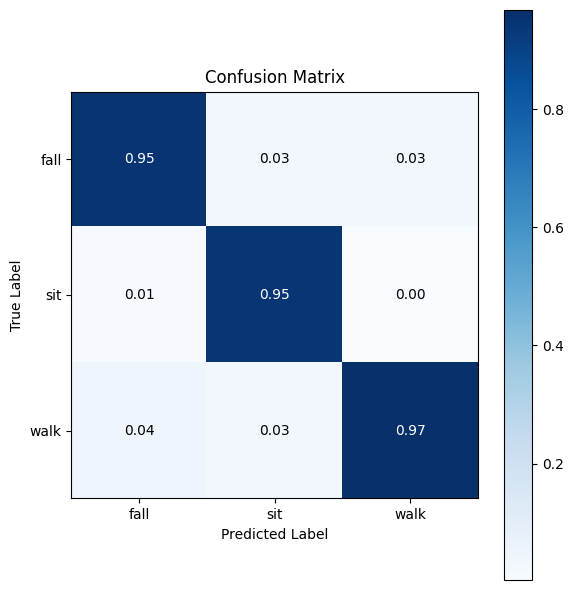

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Carica il miglior modello salvato
best_model = load_model('best_model.h5')

# Predizioni
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converte le probabilità in classi predette
y_test_classes = np.argmax(y_test, axis=1)  # Converte y_test in etichette numeriche

# Calcolo della matrice di confusione
cm = confusion_matrix(y_test_classes, y_pred_classes)  # Ora i formati coincidono
cm_normalized = cm.astype('float') / cm.sum(axis=0)  # Normalizza per colonna (opzionale)

print("Confusion Matrix Normalized:\n", cm_normalized)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(6, 6))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Etichette delle classi, aggiorna se necessario
class_labels = ['fall', 'sit', 'walk']

# Imposta le etichette degli assi
plt.xticks(np.arange(len(class_labels)), class_labels)
plt.yticks(np.arange(len(class_labels)), class_labels)

# Aggiunta dei valori all'interno delle celle
thresh = cm_normalized.max() / 2.  # Imposta una soglia per la colorazione del testo
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, f"{cm_normalized[i, j]:.2f}", ha="center", va="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

plt.tight_layout()  # Assicura che la visualizzazione sia ottimizzata
plt.show()
